# **IST 736: Text Mining**

**Nikita Ramsey**


Homework #6

# Introduction:

For this assignment, we'll be using restaurant review data to create prediction models for lies and sentiment (similar to Homework #4). However, for this assignment we'll be implementing various experimental designs for both the Benoulli and Multinomial Naive Bayes algorithms in sklearn.



We'll first start by installing and loading the necessary libraries.

In [1]:
# Install libraries
!pip install seaborn spacy nltk pandas matplotlib contractions textblob ace_tools

In [2]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import contractions
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

# **Data:**

This data was obtained from the an inclass resource and contains 92 rows and 3 columns.
The three columns include:


*   Lie (str)
*   Sentiment (str)
*   Review (str)



Here I'm going to load and review the data.

In [3]:
# Load the data
csv_file = 'deception_data_converted_final.tsv'
df = pd.read_csv(csv_file, sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lie        92 non-null     object
 1   sentiment  92 non-null     object
 2   review     92 non-null     object
dtypes: object(3)
memory usage: 2.3+ KB


In [4]:
# Adjust the display settings
pd.set_option('display.max_colwidth', None)
df.head()

,lie,sentiment,review
0,f,n,"'Mike\'s Pizza High Point, NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza, not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where.'"
1,f,n,"'i really like this buffet restaurant in Marshall street. they have a lot of selection of american, japanese, and chinese dishes. we also got a free drink and free refill. there are also different kinds of dessert. the staff is very friendly. it is also quite cheap compared with the other restaurant in syracuse area. i will definitely coming back here.'"
2,f,n,"'After I went shopping with some of my friend, we went to DODO restaurant for dinner. I found worm in one of the dishes .'"
3,f,n,"'Olive Oil Garden was very disappointing. I expect good food and good service (at least!!) when I go out to eat. The meal was cold when we got it, and the waitor had no manners whatsoever. Don\'t go to the Olive Oil Garden. '"
4,f,n,"'The Seven Heaven restaurant was never known for a superior service but what we experienced last week was a disaster. The waiter would not notice us until we asked him 4 times to bring us the menu. The food was not exceptional either. It took them though 2 minutes to bring us a check after they spotted we finished eating and are not ordering more. Well, never more. '"


**Initial preprocessing:**

To begin the preprocessing of the text, this function will be used to get the data in a clean state.

In [5]:
# Create function to clean the text
def clean_text(text):
    text = contractions.fix(text) # expand contractions
    text = re.sub(r'\d+', '', text) # removes digits
    text = re.sub(r'[^\w\s]', '', text) # removes special characters
    return text.lower().strip() # makes lowercase and removes whitespace

In [6]:
# Clean the text and add to df
df['cleaned_text'] = df['review'].apply(clean_text)

# Compare text to ensure proper cleaning steps were applies
df['review']

,review
0,"'Mike\'s Pizza High Point, NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza, not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where.'"
1,"'i really like this buffet restaurant in Marshall street. they have a lot of selection of american, japanese, and chinese dishes. we also got a free drink and free refill. there are also different kinds of dessert. the staff is very friendly. it is also quite cheap compared with the other restaurant in syracuse area. i will definitely coming back here.'"
2,"'After I went shopping with some of my friend, we went to DODO restaurant for dinner. I found worm in one of the dishes .'"
3,"'Olive Oil Garden was very disappointing. I expect good food and good service (at least!!) when I go out to eat. The meal was cold when we got it, and the waitor had no manners whatsoever. Don\'t go to the Olive Oil Garden. '"
4,"'The Seven Heaven restaurant was never known for a superior service but what we experienced last week was a disaster. The waiter would not notice us until we asked him 4 times to bring us the menu. The food was not exceptional either. It took them though 2 minutes to bring us a check after they spotted we finished eating and are not ordering more. Well, never more. '"
...,...
87,'Pastablities is a locally owned restaurant in Syracuse. The food is simple and homey and comforting. Their famous bread is baked daily and the bakery is right next door. The bread is soft and chewy and amazing with their homemade spicy tomato sauce. The paste and cheese that I had was cream and cooked to perfection. '
88,"'I like the Pizza at Dominoes for their special ingredients and the prices, they give out one of the best pizza\'s in town. I ordered Special Pepperoni Pizza (large) from the online portal which gives me a discount of 50\% for being a regular customer, they always provide a good quantity of cheese over the pizza, we generally do not need to add a topping of pizza cheese for cheese lovers compared to other places. The place has a nice ambient environment, it is generally empty as it has more delivery orders than dine in. Orders are processed very quickly and has a special taste to it. Cost friendly prices makes me pick it up as my best buy. Overall Rating : 5/5'"
89,'It was a really amazing Japanese restaurant. The waiter has friendly smile. The environment is very nice. And the food is fresh.'
90,"'How do I even pick a best experience at Joe\'s Noodle House? It\'s hard to find an authentic Chinese restaurant anywhere in the United States: what we think of as Chinese food is really American food with a few Chinese ingredients. (Chinese food is not usually deep-fried and is virtually never sweet.) A restaurant with a name like \'Joe\'s Noodle House\' doesn\'t sound that promising, but it\'s the best Sichuanese restaurant I\'ve been to in the United States. I\'ve become friends with the waitstaff, all of whom ask after me whenever my father visits the restaurant. It\'s really too bad it\'s in Maryland. I\'d go all the time. I can\'t find any good Chinese food in Syracuse.'"


In [7]:
# Display cleaned text
df['cleaned_text']

,cleaned_text
0,mikes pizza high point ny service was very slow and the quality was low you would think they would know at least how to make good pizza not stick to premade dishes like stuffed pasta or a salad you should consider dining else where
1,i really like this buffet restaurant in marshall street they have a lot of selection of american japanese and chinese dishes we also got a free drink and free refill there are also different kinds of dessert the staff is very friendly it is also quite cheap compared with the other restaurant in syracuse area i will definitely coming back here
2,after i went shopping with some of my friend we went to dodo restaurant for dinner i found worm in one of the dishes
3,olive oil garden was very disappointing i expect good food and good service at least when i go out to eat the meal was cold when we got it and the waitor had no manners whatsoever dont go to the olive oil garden
4,the seven heaven restaurant was never known for a superior service but what we experienced last week was a disaster the waiter would not notice us until we asked him times to bring us the menu the food was not exceptional either it took them though minutes to bring us a check after they spotted we finished eating and are not ordering more well never more
...,...
87,pastablities is a locally owned restaurant in syracuse the food is simple and homey and comforting their famous bread is baked daily and the bakery is right next door the bread is soft and chewy and amazing with their homemade spicy tomato sauce the paste and cheese that i had was cream and cooked to perfection
88,i like the pizza at dominoes for their special ingredients and the prices they give out one of the best pizzas in town i ordered special pepperoni pizza large from the online portal which gives me a discount of for being a regular customer they always provide a good quantity of cheese over the pizza we generally do not need to add a topping of pizza cheese for cheese lovers compared to other places the place has a nice ambient environment it is generally empty as it has more delivery orders than dine in orders are processed very quickly and has a special taste to it cost friendly prices makes me pick it up as my best buy overall rating
89,it was a really amazing japanese restaurant the waiter has friendly smile the environment is very nice and the food is fresh
90,how do i even pick a best experience at joes noodle house its hard to find an authentic chinese restaurant anywhere in the united states what we think of as chinese food is really american food with a few chinese ingredients chinese food is not usually deepfried and is virtually never sweet a restaurant with a name like joes noodle house doesnt sound that promising but its the best sichuanese restaurant ive been to in the united states ive become friends with the waitstaff all of whom ask after me whenever my father visits the restaurant its really too bad its in maryland i would go all the time i cant find any good chinese food in syracuse


**Exploratory Data Analysis**

Here we'll look at the distribution of text lengths, word counts, average word lengths, polarity, and lie and sentiment label distributions, in addition to creating various unigram WordClouds.

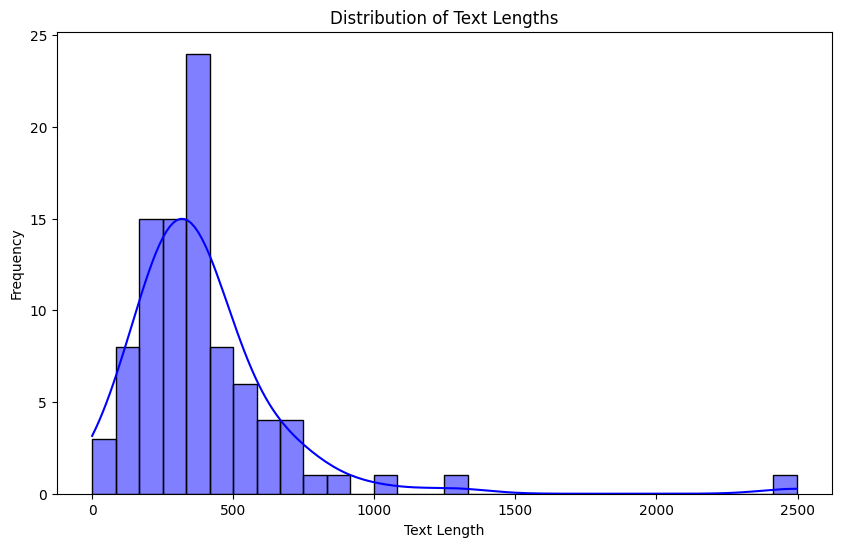

In [8]:
#1. Text length Distribution
df['text_length'] = df['cleaned_text'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(df['text_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

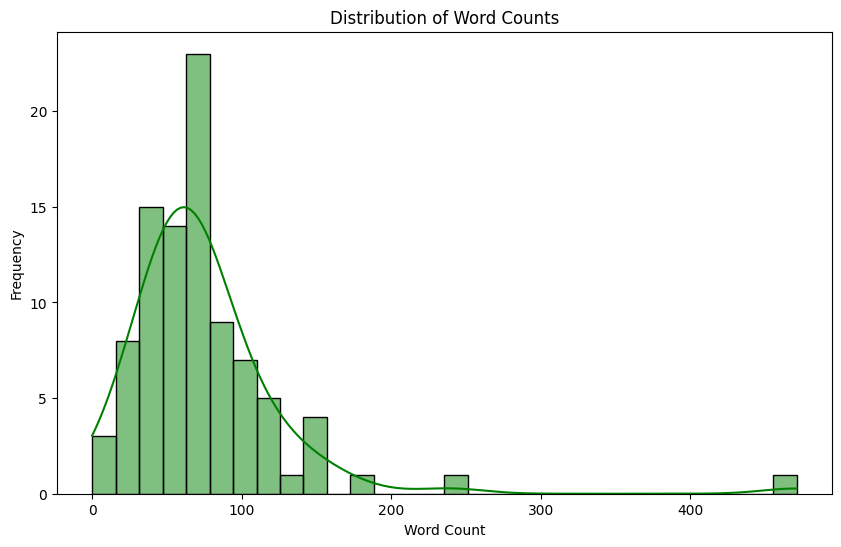

In [9]:
#2. Word Count Distribution
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(df['word_count'], bins=30, kde=True, color='green')
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

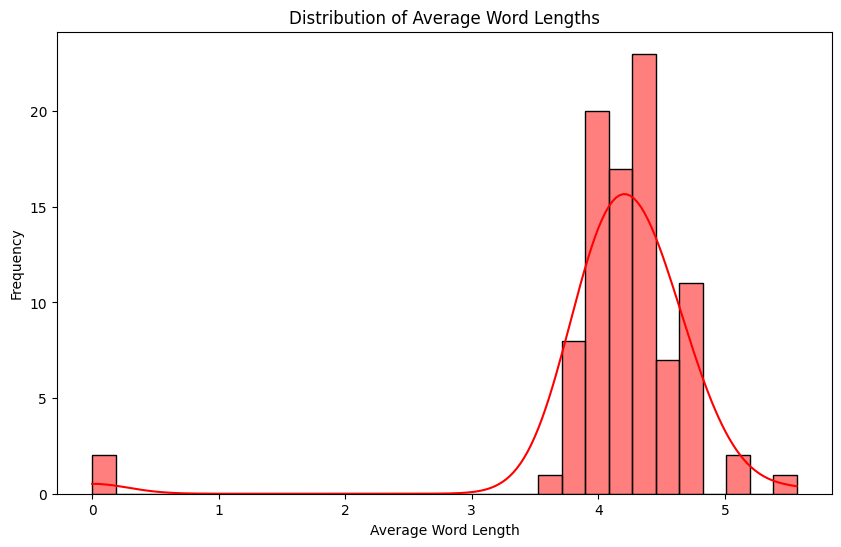

In [10]:
#3. Average Word Length Distribution
df['avg_word_length'] = df['cleaned_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)

plt.figure(figsize=(10,6))
sns.histplot(df['avg_word_length'], bins=30, kde=True, color='red')
plt.title('Distribution of Average Word Lengths')
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')
plt.show()

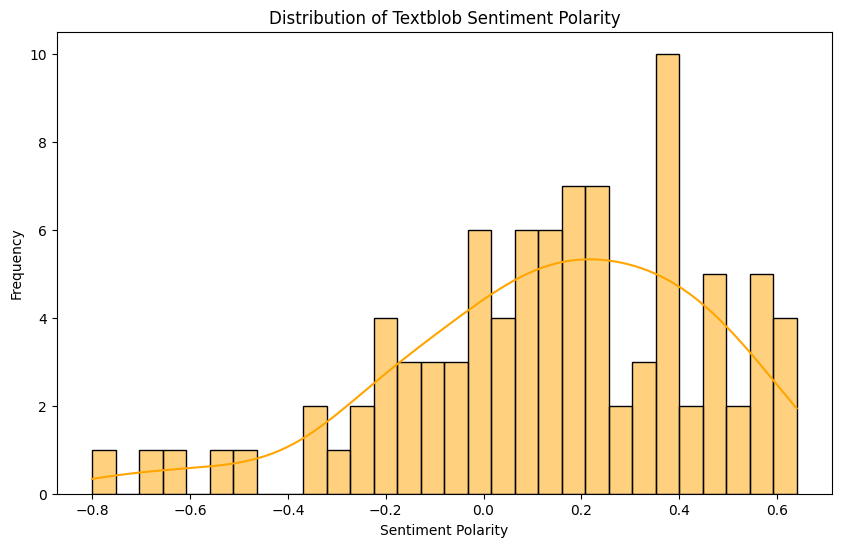

In [11]:
#4. Textblob Sentiment Polarity Distribution
df['textblob_polarity'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10,6))
sns.histplot(df['textblob_polarity'], bins=30, kde=True, color='orange')
plt.title('Distribution of Textblob Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

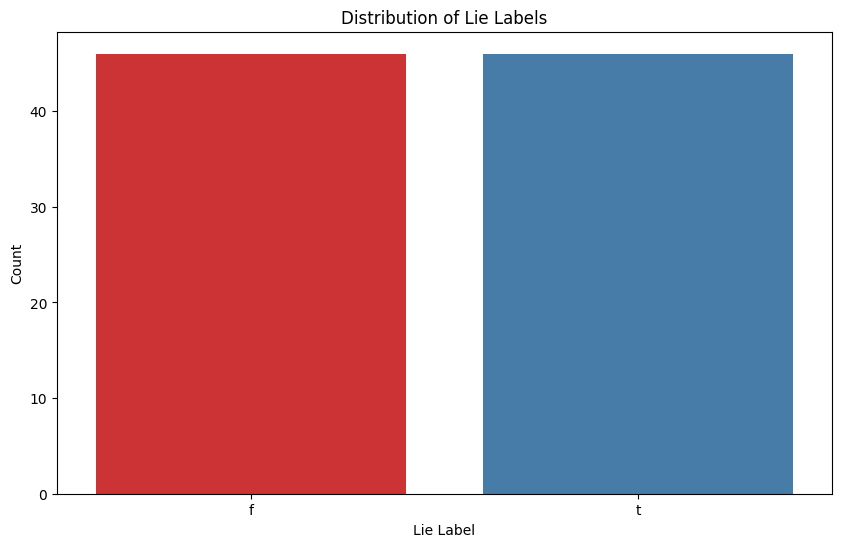

In [12]:
#5. Lie Label Distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='lie', hue='lie', palette='Set1')
plt.title('Distribution of Lie Labels')
plt.xlabel('Lie Label')
plt.ylabel('Count')
plt.show()

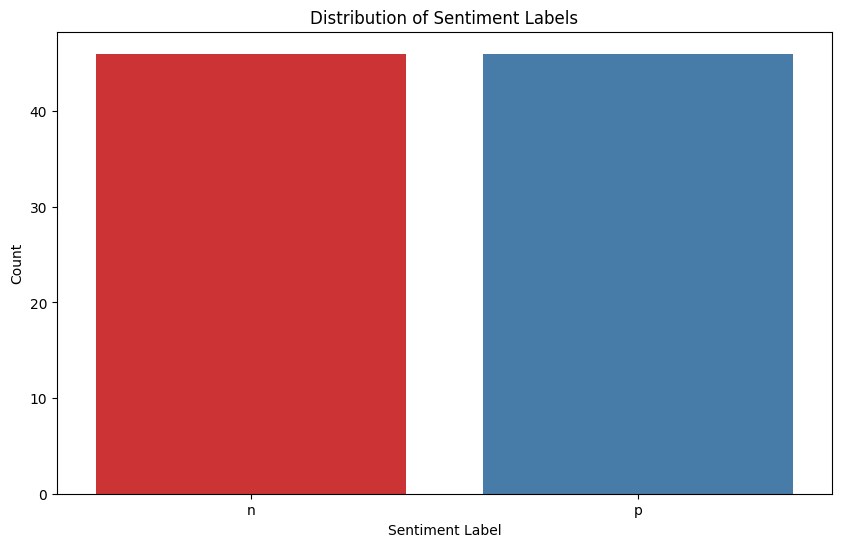

In [13]:
#6. Sentiment Label Distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='sentiment', hue='sentiment', palette='Set1')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

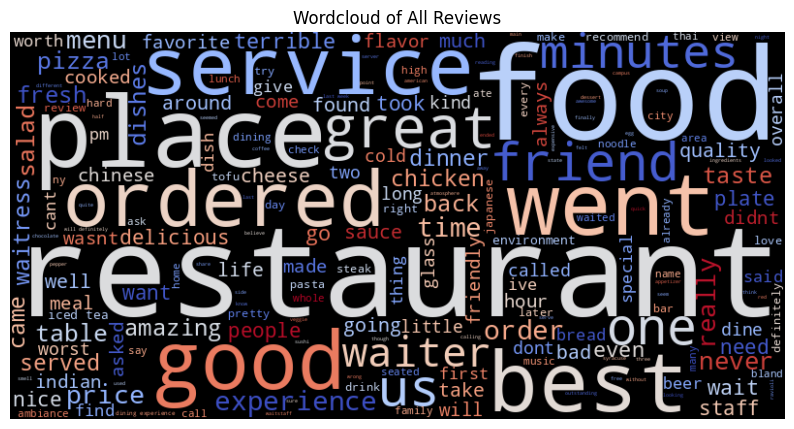

In [14]:
#7. Wordclouds
all_text = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate(all_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of All Reviews')
plt.show()

In [15]:
# Load spacy for wc preprocessing
nlp = spacy.load('en_core_web_sm')

# Create tokenizer for text preprocessing of wordcloud
def preprocess_text_for_wc(text):
  doc = nlp(text.lower())
  return [token for token in doc if not token.is_stop and not token.is_punct]

In [16]:
# Preprocess text for wc and calculate word frequencies
df['wc_processed_text'] = df['cleaned_text'].apply(preprocess_text_for_wc)
all_words = [str(word) for words in df['wc_processed_text'] for word in words]
word_freq = Counter(all_words)
word_freq

Counter({'mikes': 1,
         'pizza': 14,
         'high': 5,
         'point': 4,
         'ny': 5,
         'service': 28,
         'slow': 2,
         'quality': 10,
         'low': 3,
         'think': 4,
         'know': 3,
         'good': 29,
         'stick': 1,
         'premade': 1,
         'dishes': 14,
         'like': 22,
         'stuffed': 2,
         'pasta': 5,
         'salad': 15,
         'consider': 1,
         'dining': 10,
         'buffet': 3,
         'restaurant': 75,
         'marshall': 3,
         'street': 4,
         'lot': 4,
         'selection': 1,
         'american': 4,
         'japanese': 6,
         'chinese': 9,
         'got': 3,
         'free': 4,
         'drink': 2,
         'refill': 1,
         'different': 4,
         'kinds': 1,
         'dessert': 3,
         'staff': 10,
         'friendly': 9,
         'cheap': 3,
         'compared': 2,
         'syracuse': 4,
         'area': 5,
         'definitely': 10,
         'coming': 3,
   

In [17]:
# Sort word frequencies from most to least
sorted_word_frequencies = word_freq.most_common()
for word, freq in sorted_word_frequencies:
    print(f"{word}: {freq}")

food: 80
restaurant: 75
 : 56
nt: 43
place: 43
went: 34
best: 31
good: 29
service: 28
ordered: 27
great: 24
minutes: 23
experience: 23
like: 22
friends: 19
salad: 15
menu: 15
plate: 15
pizza: 14
dishes: 14
order: 14
time: 14
fresh: 14
amazing: 14
came: 13
served: 13
chicken: 13
waitress: 13
taste: 13
dinner: 12
waiter: 12
terrible: 12
wait: 12
took: 11
overall: 11
table: 11
people: 11
delicious: 11
want: 11
nice: 11
prices: 11
quality: 10
dining: 10
staff: 10
definitely: 10
found: 10
bad: 10
going: 10
life: 10
cheese: 10
sauce: 10
chinese: 9
friendly: 9
meal: 9
asked: 9
favorite: 9
cooked: 9
cold: 8
dine: 8
worst: 8
called: 8
come: 8
little: 8
long: 8
need: 8
indian: 8
glass: 8
said: 7
kind: 7
iced: 7
tea: 7
pm: 7
worth: 7
dish: 7
special: 7
bread: 7
find: 7
ve: 7
environment: 7
japanese: 6
hour: 6
recommend: 6
later: 6
steak: 6
ice: 6
price: 6
try: 6
waiters: 6
right: 6
bar: 6
pretty: 6
tofu: 6
high: 5
ny: 5
pasta: 5
area: 5
bring: 5
check: 5
family: 5
seated: 5
bland: 5
waited: 5
har

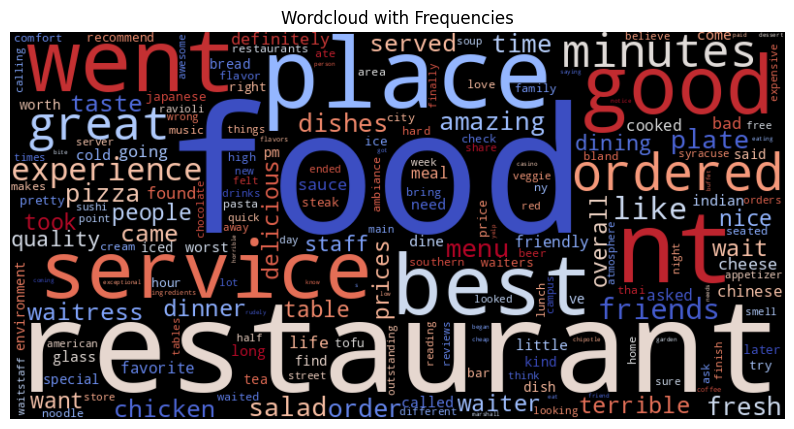

In [18]:
#8. Wordcloud with Frequencies
wordcloud_withFreq = WordCloud(width=800, height=400, background_color='black', colormap="coolwarm").generate_from_frequencies(word_freq)

plt.figure(figsize=(10,6))
plt.title('Wordcloud with Frequencies')
plt.imshow(wordcloud_withFreq, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
# Subset the reviews by lie labels
t_reviews = ' '.join(df[df['lie'] == 't']['cleaned_text'])
f_reviews = ' '.join(df[df['lie'] == 'f']['cleaned_text'])

# Subset the reviews by sentiment labels
n_reviews = ' '.join(df[df['sentiment'] == 'n']['cleaned_text'])
p_reviews = ' '.join(df[df['sentiment'] == 'p']['cleaned_text'])

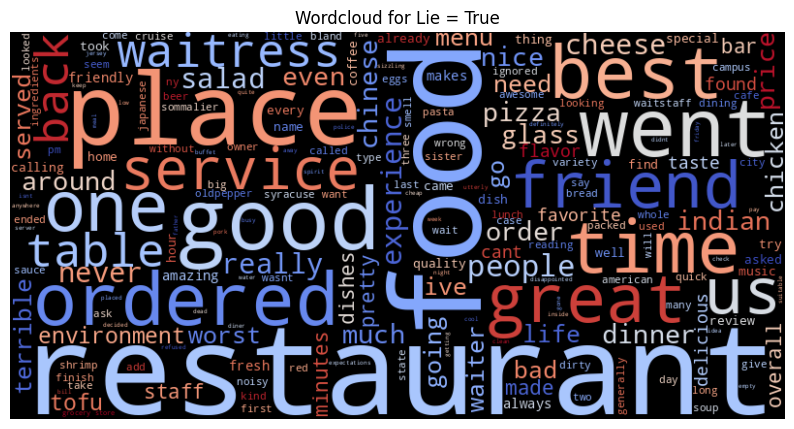

In [20]:
#9. Wordcloud: Reviews with lie = True
wordcloud_t = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate(t_reviews)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_t, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Lie = True')
plt.show()

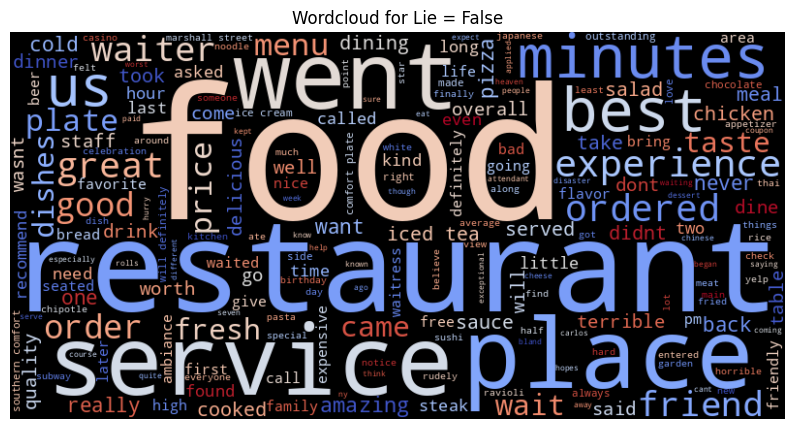

In [21]:
#10. Wordcloud: Reviews with lie = False
wordcloud_f = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate(f_reviews)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_f, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Lie = False')
plt.show()

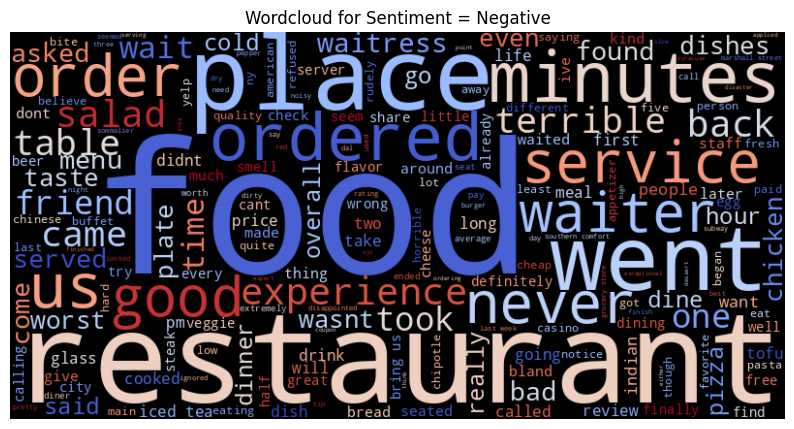

In [22]:
#11. Wordcloud: Reviews with sentiment = Negative
wordcloud_n = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate(n_reviews)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_n, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Sentiment = Negative')
plt.show()

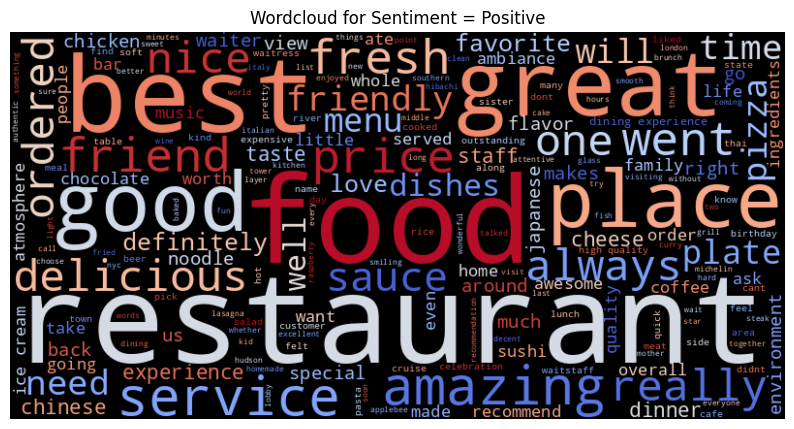

In [23]:
#13. Wordcloud 4: Reviews with sentiment = Positive
wordcloud_p = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate(p_reviews)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_p, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Sentiment = Positive')
plt.show()

# **Methods and Models**

To address this classification problem, Multinomial Naive Bayes will be used to predict the sentiment and lie labels for the food review data.



**Multinomial Naive Bayes (MultinomialNB):**



MultinomialNB is a probabilistic classifier that uses Bayes' theorem to predict class membership. It assumes that the features (e.g., words or n-grams) are conditionally independent given the class label. This model is particularly effective for text classification tasks where word frequency is important.


**Bernoulli Naïve Bayes (BernoulliNB):**



BernoulliNB is a probabilistic classifier based on Bayes' theorem, designed for binary feature representations. Unlike MultinomialNB, which considers word frequencies, BernoulliNB models the presence or absence of words in a document (i.e., whether a word appears at least once). This makes it particularly effective for tasks where binary term occurrence is more informative than raw frequency, such as short text classification or sentiment analysis when feature sparsity is high.

**Experimental Design**

After completing EDA, we'll now lemmatize the text, then create multiple vectorizers utilizing various parameters. From there, we'll pass the vectorized text to MNB and BNB to train the model for prediction.

In [24]:
# Review dataframe
df.head()

,lie,sentiment,review,cleaned_text,text_length,word_count,avg_word_length,textblob_polarity,wc_processed_text
0,f,n,"'Mike\'s Pizza High Point, NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza, not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where.'",mikes pizza high point ny service was very slow and the quality was low you would think they would know at least how to make good pizza not stick to premade dishes like stuffed pasta or a salad you should consider dining else where,231,44,4.272727,0.034000,"[mikes, pizza, high, point, ny, service, slow, quality, low, think, know, good, pizza, stick, premade, dishes, like, stuffed, pasta, salad, consider, dining]"
1,f,n,"'i really like this buffet restaurant in Marshall street. they have a lot of selection of american, japanese, and chinese dishes. we also got a free drink and free refill. there are also different kinds of dessert. the staff is very friendly. it is also quite cheap compared with the other restaurant in syracuse area. i will definitely coming back here.'",i really like this buffet restaurant in marshall street they have a lot of selection of american japanese and chinese dishes we also got a free drink and free refill there are also different kinds of dessert the staff is very friendly it is also quite cheap compared with the other restaurant in syracuse area i will definitely coming back here,344,61,4.655738,0.146875,"[like, buffet, restaurant, marshall, street, lot, selection, american, japanese, chinese, dishes, got, free, drink, free, refill, different, kinds, dessert, staff, friendly, cheap, compared, restaurant, syracuse, area, definitely, coming]"
2,f,n,"'After I went shopping with some of my friend, we went to DODO restaurant for dinner. I found worm in one of the dishes .'",after i went shopping with some of my friend we went to dodo restaurant for dinner i found worm in one of the dishes,116,24,3.875000,0.000000,"[went, shopping, friend, went, dodo, restaurant, dinner, found, worm, dishes]"
3,f,n,"'Olive Oil Garden was very disappointing. I expect good food and good service (at least!!) when I go out to eat. The meal was cold when we got it, and the waitor had no manners whatsoever. Don\'t go to the Olive Oil Garden. '",olive oil garden was very disappointing i expect good food and good service at least when i go out to eat the meal was cold when we got it and the waitor had no manners whatsoever dont go to the olive oil garden,211,43,3.930233,-0.056000,"[olive, oil, garden, disappointing, expect, good, food, good, service, eat, meal, cold, got, waitor, manners, whatsoever, nt, olive, oil, garden]"
4,f,n,"'The Seven Heaven restaurant was never known for a superior service but what we experienced last week was a disaster. The waiter would not notice us until we asked him 4 times to bring us the menu. The food was not exceptional either. It took them though 2 minutes to bring us a check after they spotted we finished eating and are not ordering more. Well, never more. '",the seven heaven restaurant was never known for a superior service but what we experienced last week was a disaster the waiter would not notice us until we asked him times to bring us the menu the food was not exceptional either it took them though minutes to bring us a check after they spotted we finished eating and are not ordering more well never more,358,66,4.409091,0.236111,"[seven, heaven, restaurant, known, superior, service, experienced, week, disaster, waiter, notice, asked, , times, bring, menu, food, exceptional, took, , minutes, bring, check, spotted, finished, eating, ordering]"


In [25]:
# Create function to lemmatize the text
def lemmatize_text(text):
  doc = nlp(text)
  return ' '.join(token.lemma_ for token in doc)

In [26]:
# Add lemmatized Text column to dataframe
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

In [27]:
# Compare cleaned text with lemmatized text to ensure application
df['cleaned_text'].head()

,cleaned_text
0,mikes pizza high point ny service was very slow and the quality was low you would think they would know at least how to make good pizza not stick to premade dishes like stuffed pasta or a salad you should consider dining else where
1,i really like this buffet restaurant in marshall street they have a lot of selection of american japanese and chinese dishes we also got a free drink and free refill there are also different kinds of dessert the staff is very friendly it is also quite cheap compared with the other restaurant in syracuse area i will definitely coming back here
2,after i went shopping with some of my friend we went to dodo restaurant for dinner i found worm in one of the dishes
3,olive oil garden was very disappointing i expect good food and good service at least when i go out to eat the meal was cold when we got it and the waitor had no manners whatsoever dont go to the olive oil garden
4,the seven heaven restaurant was never known for a superior service but what we experienced last week was a disaster the waiter would not notice us until we asked him times to bring us the menu the food was not exceptional either it took them though minutes to bring us a check after they spotted we finished eating and are not ordering more well never more


In [28]:
# Review lemmatized text column
df['lemmatized_text'].head()

,lemmatized_text
0,mike pizza high point ny service be very slow and the quality be low you would think they would know at least how to make good pizza not stick to premade dish like stuff pasta or a salad you should consider dine else where
1,I really like this buffet restaurant in marshall street they have a lot of selection of american japanese and chinese dish we also get a free drink and free refill there be also different kind of dessert the staff be very friendly it be also quite cheap compare with the other restaurant in syracuse area I will definitely come back here
2,after I went shop with some of my friend we go to dodo restaurant for dinner I find worm in one of the dish
3,olive oil garden be very disappointing I expect good food and good service at least when I go out to eat the meal be cold when we get it and the waitor have no manner whatsoever do not go to the olive oil garden
4,the seven heaven restaurant be never know for a superior service but what we experience last week be a disaster the waiter would not notice we until we ask he time to bring we the menu the food be not exceptional either it take they though minute to bring we a check after they spot we finish eat and be not order more well never more


Define intial stop words to used

In [29]:
# Review sklearn stop words
sk_stops = list(set(ENGLISH_STOP_WORDS))
sk_stops

['only',
 'hence',
 'if',
 'via',
 'such',
 'eleven',
 'since',
 'everywhere',
 'full',
 'elsewhere',
 'would',
 'throughout',
 'any',
 'often',
 'whereby',
 'onto',
 'nothing',
 'again',
 'together',
 'became',
 'find',
 'something',
 'move',
 'least',
 'un',
 'herein',
 'during',
 'her',
 'nevertheless',
 'becoming',
 'have',
 'its',
 'an',
 'out',
 'who',
 'are',
 'was',
 'as',
 'ten',
 'what',
 'through',
 'per',
 'done',
 'wherever',
 'can',
 'three',
 'still',
 'take',
 'anywhere',
 'con',
 'mostly',
 'whether',
 'he',
 'your',
 'thereby',
 'one',
 'is',
 'thence',
 'being',
 'though',
 'former',
 'less',
 'sincere',
 'within',
 'bill',
 'about',
 'cant',
 'yet',
 'sometime',
 'forty',
 'after',
 'first',
 'detail',
 'under',
 'call',
 'which',
 'eight',
 'twenty',
 'herself',
 'twelve',
 'be',
 'none',
 'however',
 'enough',
 'been',
 'therefore',
 'indeed',
 'empty',
 'than',
 'front',
 'six',
 'over',
 'next',
 'no',
 'anything',
 'others',
 'that',
 're',
 'many',
 'should',


In [30]:
# Review NLTK stop words
nltk.download('stopwords')
nltk_stops = list(set(stopwords.words('english')))
nltk_stops

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['but',
 'a',
 'couldn',
 'him',
 'only',
 'how',
 'll',
 "it'll",
 "i'd",
 'if',
 'once',
 "she'll",
 'such',
 'into',
 "we're",
 'some',
 "haven't",
 'mightn',
 'any',
 "it's",
 'all',
 "should've",
 'again',
 "wouldn't",
 'ma',
 "wasn't",
 "they'd",
 'having',
 'this',
 "mustn't",
 'doing',
 'these',
 "needn't",
 "shouldn't",
 "you've",
 'those',
 'during',
 'were',
 "he'd",
 'her',
 'them',
 "i'll",
 "that'll",
 'to',
 "they've",
 "won't",
 'below',
 'hasn',
 "don't",
 'have',
 'its',
 'an',
 'now',
 'out',
 'not',
 'do',
 'who',
 'did',
 "it'd",
 "she'd",
 'they',
 'are',
 'was',
 'as',
 'myself',
 "didn't",
 'wasn',
 "isn't",
 'what',
 'through',
 'am',
 'itself',
 'shouldn',
 'can',
 "you'd",
 'does',
 "weren't",
 'both',
 'it',
 'he',
 'doesn',
 'each',
 'because',
 'whom',
 'your',
 'most',
 'm',
 've',
 'is',
 'needn',
 'wouldn',
 'between',
 'being',
 'before',
 'yours',
 'shan',
 "hasn't",
 'she',
 'hers',
 "mightn't",
 'hadn',
 'about',
 'from',
 "we'd",
 'ain',
 'after',


In [31]:
# Create custom stops from word clouds and frequency counts
custom_stops = ['food','restaurant', ' ', 'or', 'also', 'for,','nt', 'place', 'went', 'they','a','i','he', 'she', 'we', 'you', 'the', 'to', 'in', 'if', 'at', 'of', 'on', 'your', 'by','and', 'but', 'when', 'who', 'why', 'with', 'work', 'write', 've']

In [32]:
# Review dataframe
df.head()

,lie,sentiment,review,cleaned_text,text_length,word_count,avg_word_length,textblob_polarity,wc_processed_text,lemmatized_text
0,f,n,"'Mike\'s Pizza High Point, NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza, not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where.'",mikes pizza high point ny service was very slow and the quality was low you would think they would know at least how to make good pizza not stick to premade dishes like stuffed pasta or a salad you should consider dining else where,231,44,4.272727,0.034000,"[mikes, pizza, high, point, ny, service, slow, quality, low, think, know, good, pizza, stick, premade, dishes, like, stuffed, pasta, salad, consider, dining]",mike pizza high point ny service be very slow and the quality be low you would think they would know at least how to make good pizza not stick to premade dish like stuff pasta or a salad you should consider dine else where
1,f,n,"'i really like this buffet restaurant in Marshall street. they have a lot of selection of american, japanese, and chinese dishes. we also got a free drink and free refill. there are also different kinds of dessert. the staff is very friendly. it is also quite cheap compared with the other restaurant in syracuse area. i will definitely coming back here.'",i really like this buffet restaurant in marshall street they have a lot of selection of american japanese and chinese dishes we also got a free drink and free refill there are also different kinds of dessert the staff is very friendly it is also quite cheap compared with the other restaurant in syracuse area i will definitely coming back here,344,61,4.655738,0.146875,"[like, buffet, restaurant, marshall, street, lot, selection, american, japanese, chinese, dishes, got, free, drink, free, refill, different, kinds, dessert, staff, friendly, cheap, compared, restaurant, syracuse, area, definitely, coming]",I really like this buffet restaurant in marshall street they have a lot of selection of american japanese and chinese dish we also get a free drink and free refill there be also different kind of dessert the staff be very friendly it be also quite cheap compare with the other restaurant in syracuse area I will definitely come back here
2,f,n,"'After I went shopping with some of my friend, we went to DODO restaurant for dinner. I found worm in one of the dishes .'",after i went shopping with some of my friend we went to dodo restaurant for dinner i found worm in one of the dishes,116,24,3.875000,0.000000,"[went, shopping, friend, went, dodo, restaurant, dinner, found, worm, dishes]",after I went shop with some of my friend we go to dodo restaurant for dinner I find worm in one of the dish
3,f,n,"'Olive Oil Garden was very disappointing. I expect good food and good service (at least!!) when I go out to eat. The meal was cold when we got it, and the waitor had no manners whatsoever. Don\'t go to the Olive Oil Garden. '",olive oil garden was very disappointing i expect good food and good service at least when i go out to eat the meal was cold when we got it and the waitor had no manners whatsoever dont go to the olive oil garden,211,43,3.930233,-0.056000,"[olive, oil, garden, disappointing, expect, good, food, good, service, eat, meal, cold, got, waitor, manners, whatsoever, nt, olive, oil, garden]",olive oil garden be very disappointing I expect good food and good service at least when I go out to eat the meal be cold when we get it and the waitor have no manner whatsoever do not go to the olive oil garden
4,f,n,"'The Seven Heaven restaurant was never known for a superior service but what we experienced last week was a disaster. The waiter would not notice us until we asked him 4 times to bring us the menu. The food was not exceptional either. It took them though 2 minutes to bring us a check after they spotted we finished eating and are not ordering more. Well, never more. '"

Divide the data so there's a training and text set for both preiction models

In [33]:
# Split the data into training and test sets
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(df['lemmatized_text'], df['sentiment'], test_size=0.10, random_state=42, stratify= df['sentiment'])

#Display the splits
print(f"Training set size: {len(X_train_sentiment)}")
print(f"Test set size: {len(X_test_sentiment)}")

Training set size: 82
Test set size: 10


In [34]:
X_train_lie, X_test_lie, y_train_lie, y_test_lie = train_test_split(df['lemmatized_text'], df['lie'], test_size=0.10, random_state=42, stratify= df['lie'])

#Display the splits
print(f"Training set size: {len(X_train_lie)}")
print(f"Test set size: {len(X_test_lie)}")

Training set size: 82
Test set size: 10


Initialize vectorizers:

Here I'll be trying out 5 different experimental designs for the Count and TFIDF vectorizers. All count vectorizer implementations are set to word presence (binary=True) since those will be used with the Bernoulli models. Using different implementations of stop words and ngrams will help to identify which has the strongest impact on model performance for this dataset.


*   Base implementation (no parms set)
*   Base implementation w/ NLTK stop words
*   Base implementation w/ SK stop words
*   Base implementation w/ Ngrams (1,3)
*   Base implementation w/ Ngrams (2,3)



In [35]:
# Define vectorizers dynamically
vectorizers = {
    # CountVectorizer for BernoulliNB
    'Base Count': CountVectorizer(binary=True),
    'Count Sklearn Stops': CountVectorizer(binary=True, stop_words=sk_stops),
    'Count NLTK Stops': CountVectorizer(binary=True, stop_words=nltk_stops),

    # Define separate vectorizers for different n-gram ranges
    'Count N-Grams (1,3)': CountVectorizer(binary=True, ngram_range=(1,3)),
    'Count N-Grams (2,3)': CountVectorizer(binary=True, ngram_range=(2,3)),

    # TF-IDF for MultinomialNB
    'Base TF-IDF': TfidfVectorizer(),
    'TF-IDF Sklearn Stops': TfidfVectorizer(stop_words=sk_stops),
    'TF-IDF NLTK Stops': TfidfVectorizer(stop_words=nltk_stops),

    # Define separate vectorizers for different TF-IDF n-gram ranges
    'TF-IDF N-Grams (1,3)': TfidfVectorizer(ngram_range=(1,3)),
    'TF-IDF N-Grams (2,3)': TfidfVectorizer(ngram_range=(2,3))
}

In [36]:
# Define models with hyperparameters using paramgrid
models = {
    'MultinomialNB': {
        'classifier': MultinomialNB(),
        'vectorizers': ['Base TF-IDF', 'TF-IDF Sklearn Stops', 'TF-IDF NLTK Stops', 'TF-IDF N-Grams (1,3)', 'TF-IDF N-Grams (2,3)'],
        'param_grid': {
            'classifier__alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0],
            'vectorizer__max_features': [15, 25, 50, 100, 125, 150]
        }
    },
    'BernoulliNB': {
        'classifier': BernoulliNB(),
        'vectorizers': ['Base Count', 'Count Sklearn Stops', 'Count NLTK Stops', 'Count N-Grams (1,3)', 'Count N-Grams (2,3)'],
        'param_grid': {
            'classifier__alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0],
            'vectorizer__max_features': [15, 25, 50, 100, 125, 150]
        }
    }
}

In [37]:
# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=42)

**Training sentiment model**

In [38]:
# Train sentiment models with Grid Search
grid_results = {}

for model_name, model_info in models.items():
    classifier = model_info['classifier']
    param_grid = model_info['param_grid']

    for vec_name in model_info['vectorizers']:
        vectorizer = vectorizers[vec_name]  # Get corresponding vectorizer

        print(f"Training {model_name} with {vec_name}...")

        # Define pipeline with vectorizer and classifier
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])

        # Run Grid Search
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=1
        )
        grid_search.fit(X_train_sentiment, y_train_sentiment) # Use raw text input (vectorizer applied in pipeline)

        # Store the best results
        grid_results[(vec_name, model_name)] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'best_model': grid_search.best_estimator_,
            'grid_search': grid_search  # Keeping full GridSearchCV in case needed later
        }

Training MultinomialNB with Base TF-IDF...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training MultinomialNB with TF-IDF Sklearn Stops...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training MultinomialNB with TF-IDF NLTK Stops...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training MultinomialNB with TF-IDF N-Grams (1,3)...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training MultinomialNB with TF-IDF N-Grams (2,3)...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training BernoulliNB with Base Count...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training BernoulliNB with Count Sklearn Stops...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training BernoulliNB with Count NLTK Stops...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training BernoulliNB with Count N-Grams (1,3)...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
T

In [39]:
# Store test evaluation results
sentiment_metrics = []

for (vec_name, model_name), result in grid_results.items():
    best_model = result['best_model']

    # Transform test data using the best vectorizer inside the pipeline
    y_pred = best_model.predict(X_test_sentiment)

    # Compute metrics
    accuracy = accuracy_score(y_test_sentiment, y_pred)
    f1 = f1_score(y_test_sentiment, y_pred, pos_label='p')
    recall = recall_score(y_test_sentiment, y_pred, pos_label='p')

    # Store results
    sentiment_metrics.append({
        'Model': f"{vec_name} + {model_name}",
        'Best Params': result['best_params'],
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'Confusion Matrix': confusion_matrix(y_test_sentiment, y_pred)
    })


🔹 Base TF-IDF + MultinomialNB Metrics:
✅ Best Parameters: {'classifier__alpha': 1.0, 'vectorizer__max_features': 150}
🔹 Accuracy: 1.00
🔹 F1 Score: 1.00
🔹 Recall: 1.00


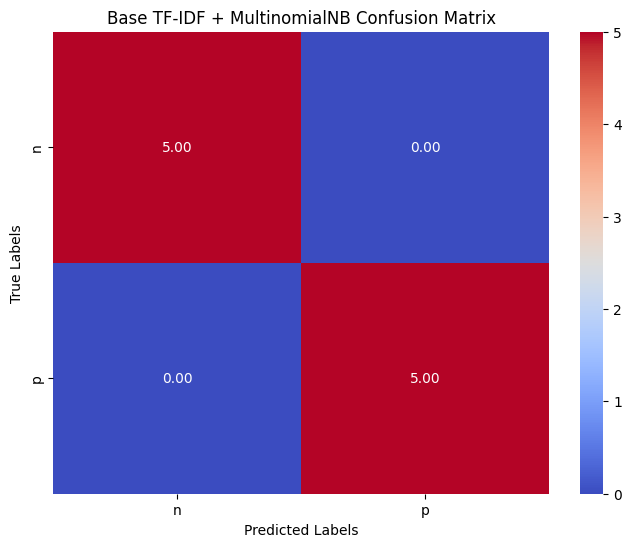


🔹 TF-IDF Sklearn Stops + MultinomialNB Metrics:
✅ Best Parameters: {'classifier__alpha': 1.0, 'vectorizer__max_features': 150}
🔹 Accuracy: 0.70
🔹 F1 Score: 0.57
🔹 Recall: 0.40


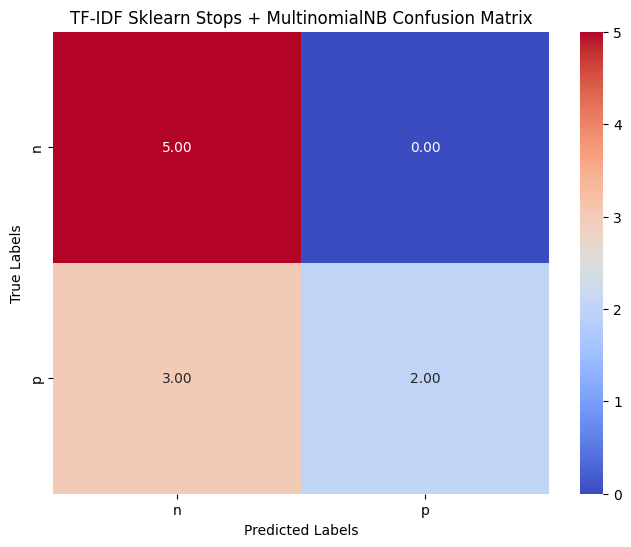


🔹 TF-IDF NLTK Stops + MultinomialNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.25, 'vectorizer__max_features': 125}
🔹 Accuracy: 0.80
🔹 F1 Score: 0.75
🔹 Recall: 0.60


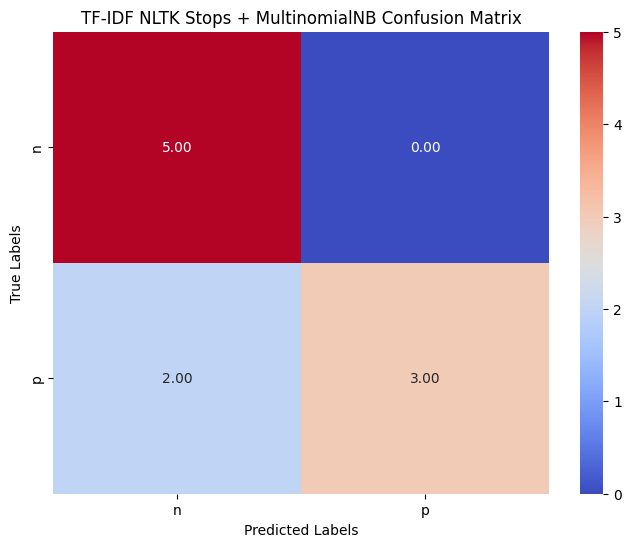


🔹 TF-IDF N-Grams (1,3) + MultinomialNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.25, 'vectorizer__max_features': 125}
🔹 Accuracy: 0.90
🔹 F1 Score: 0.89
🔹 Recall: 0.80


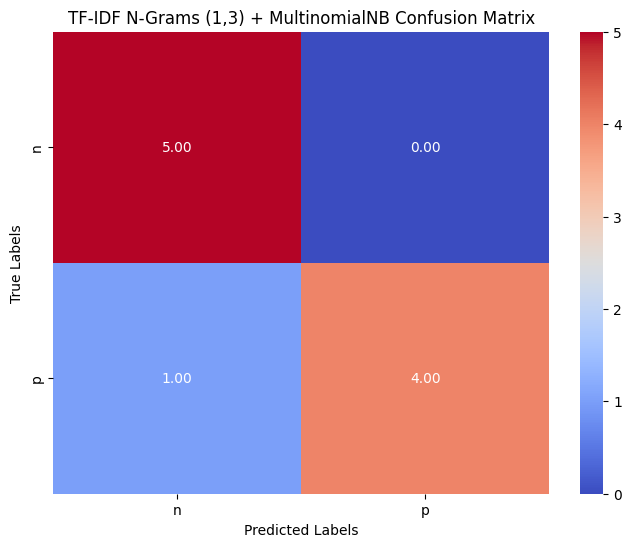


🔹 TF-IDF N-Grams (2,3) + MultinomialNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.25, 'vectorizer__max_features': 15}
🔹 Accuracy: 0.60
🔹 F1 Score: 0.50
🔹 Recall: 0.40


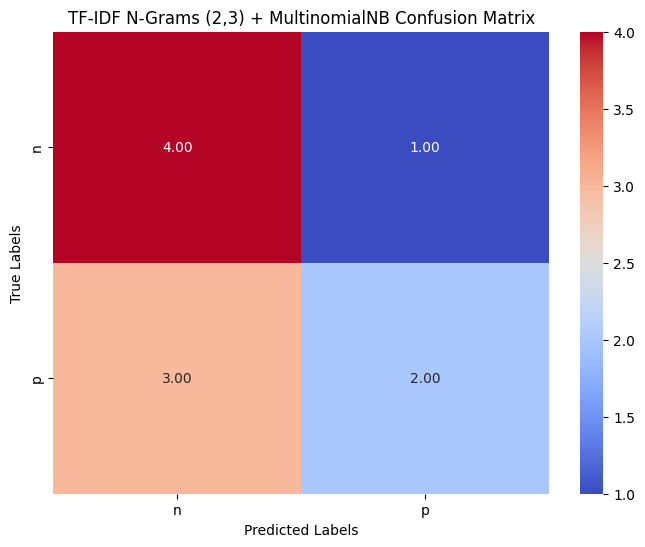


🔹 Base Count + BernoulliNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.01, 'vectorizer__max_features': 150}
🔹 Accuracy: 0.90
🔹 F1 Score: 0.91
🔹 Recall: 1.00


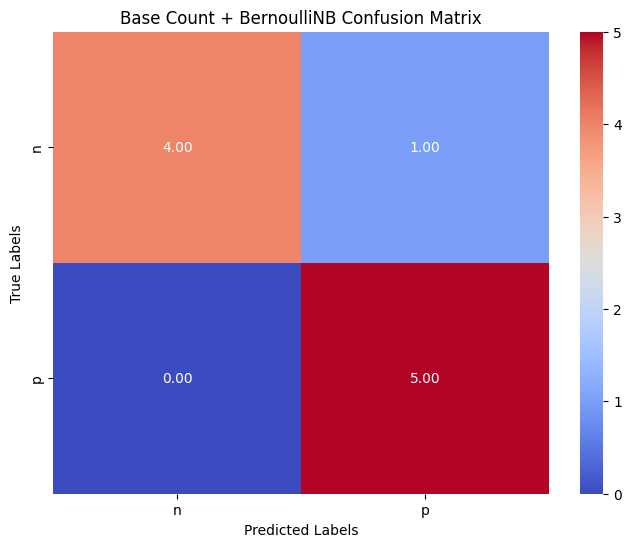


🔹 Count Sklearn Stops + BernoulliNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.5, 'vectorizer__max_features': 150}
🔹 Accuracy: 0.90
🔹 F1 Score: 0.91
🔹 Recall: 1.00


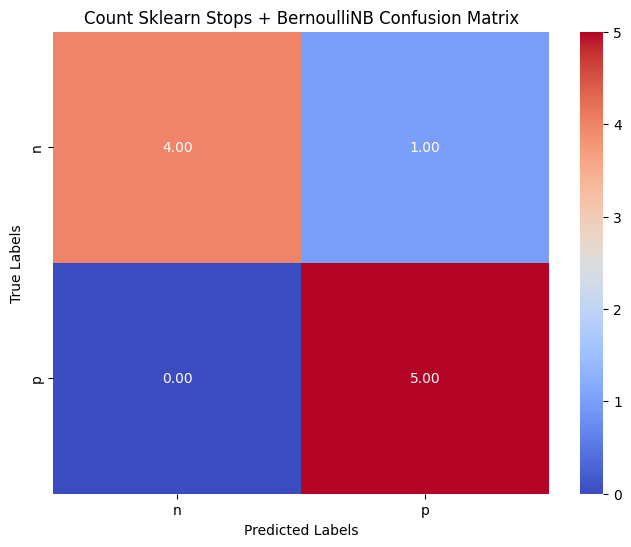


🔹 Count NLTK Stops + BernoulliNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.1, 'vectorizer__max_features': 100}
🔹 Accuracy: 0.90
🔹 F1 Score: 0.91
🔹 Recall: 1.00


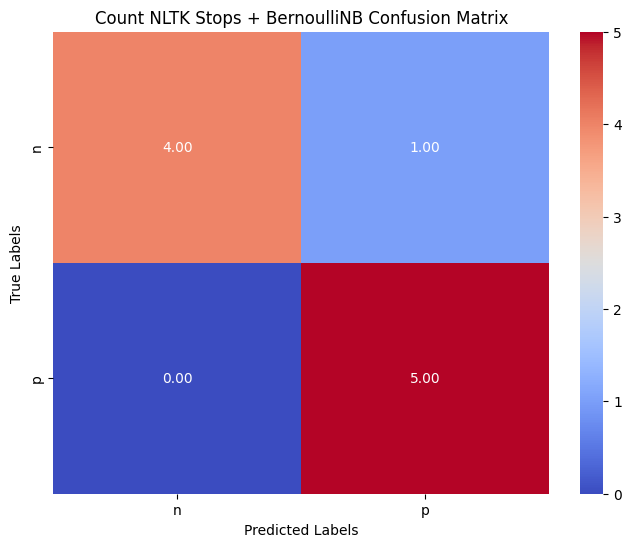


🔹 Count N-Grams (1,3) + BernoulliNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.1, 'vectorizer__max_features': 150}
🔹 Accuracy: 0.90
🔹 F1 Score: 0.91
🔹 Recall: 1.00


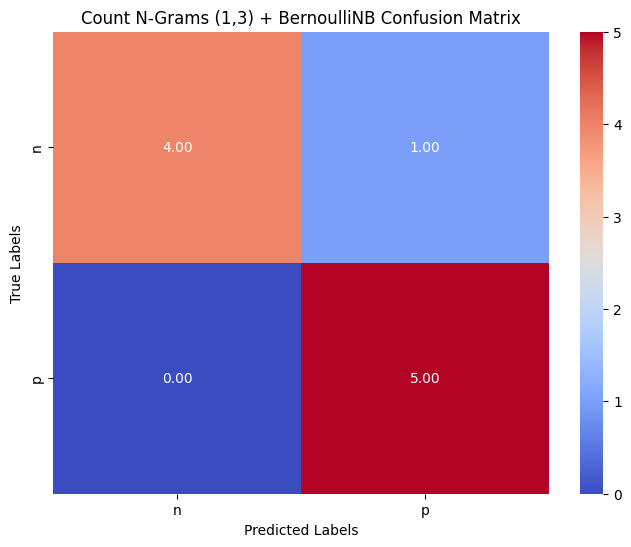


🔹 Count N-Grams (2,3) + BernoulliNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.5, 'vectorizer__max_features': 100}
🔹 Accuracy: 0.60
🔹 F1 Score: 0.50
🔹 Recall: 0.40


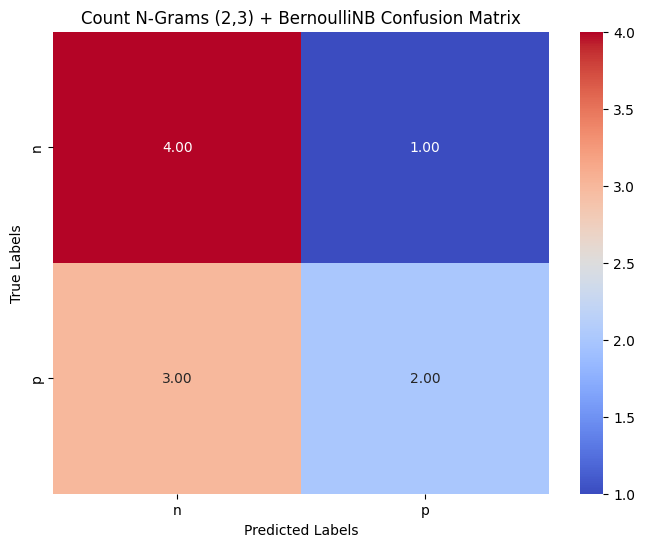

In [40]:
# Print best model parameters and evaluation metrics
for result in sentiment_metrics:
    print(f"\n🔹 {result['Model']} Metrics:")
    print(f"✅ Best Parameters: {result['Best Params']}")
    print(f"🔹 Accuracy: {result['Accuracy']:.2f}")
    print(f"🔹 F1 Score: {result['F1 Score']:.2f}")
    print(f"🔹 Recall: {result['Recall']:.2f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(result['Confusion Matrix'], annot=True, cmap="coolwarm", fmt=".2f",
                xticklabels=np.unique(y_test_sentiment), yticklabels=np.unique(y_test_sentiment))
    plt.title(f"{result['Model']} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [41]:
# Convert test results to DataFrame for visualization
sentiment_metrics_results_df = pd.DataFrame(sentiment_metrics)

# Display the metrics comparison
print("\nSentiment Metrics Comparison:")
print(sentiment_metrics_results_df.iloc[:,:-1])


Sentiment Metrics Comparison:
                                  Model  \
0           Base TF-IDF + MultinomialNB   
1  TF-IDF Sklearn Stops + MultinomialNB   
2     TF-IDF NLTK Stops + MultinomialNB   
3  TF-IDF N-Grams (1,3) + MultinomialNB   
4  TF-IDF N-Grams (2,3) + MultinomialNB   
5              Base Count + BernoulliNB   
6     Count Sklearn Stops + BernoulliNB   
7        Count NLTK Stops + BernoulliNB   
8     Count N-Grams (1,3) + BernoulliNB   
9     Count N-Grams (2,3) + BernoulliNB   

                                                    Best Params  Accuracy  \
0   {'classifier__alpha': 1.0, 'vectorizer__max_features': 150}       1.0   
1   {'classifier__alpha': 1.0, 'vectorizer__max_features': 150}       0.7   
2  {'classifier__alpha': 0.25, 'vectorizer__max_features': 125}       0.8   
3  {'classifier__alpha': 0.25, 'vectorizer__max_features': 125}       0.9   
4   {'classifier__alpha': 0.25, 'vectorizer__max_features': 15}       0.6   
5  {'classifier__alpha': 0.01, 'v

**Training lie detection models**

In [42]:
# Train lie models with Grid Search
grid_results = {}

for model_name, model_info in models.items():
    classifier = model_info['classifier']
    param_grid = model_info['param_grid']

    for vec_name in model_info['vectorizers']:
        vectorizer = vectorizers[vec_name]  # Get corresponding vectorizer

        print(f"Training {model_name} with {vec_name}...")

        # Define pipeline with vectorizer and classifier
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])

        # Run Grid Search
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=1
        )
        grid_search.fit(X_train_lie, y_train_lie) # Use raw text input (vectorizer applied in pipeline)

        # Store the best results
        grid_results[(vec_name, model_name)] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'best_model': grid_search.best_estimator_,
            'grid_search': grid_search
        }

Training MultinomialNB with Base TF-IDF...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training MultinomialNB with TF-IDF Sklearn Stops...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training MultinomialNB with TF-IDF NLTK Stops...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training MultinomialNB with TF-IDF N-Grams (1,3)...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training MultinomialNB with TF-IDF N-Grams (2,3)...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training BernoulliNB with Base Count...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training BernoulliNB with Count Sklearn Stops...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training BernoulliNB with Count NLTK Stops...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
Training BernoulliNB with Count N-Grams (1,3)...
Fitting 12 folds for each of 36 candidates, totalling 432 fits
T

In [50]:
# Store test evaluation results
lie_metrics = []

for (vec_name, model_name), result in grid_results.items():
    best_model = result['best_model']

    # Transform test data using the best vectorizer inside the pipeline
    y_pred = best_model.predict(X_test_lie)

    # Compute metrics
    accuracy = accuracy_score(y_test_lie, y_pred)
    f1 = f1_score(y_test_lie, y_pred, pos_label='t')
    recall = recall_score(y_test_lie, y_pred, pos_label='t')

    # Store results
    lie_metrics.append({
        'Model': f"{vec_name} + {model_name}",
        'Best Params': result['best_params'],
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'Confusion Matrix': confusion_matrix(y_test_lie, y_pred)
    })


🔹 Base TF-IDF + MultinomialNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.1, 'vectorizer__max_features': 50}
🔹 Accuracy: 0.40
🔹 F1 Score: 0.25
🔹 Recall: 0.20


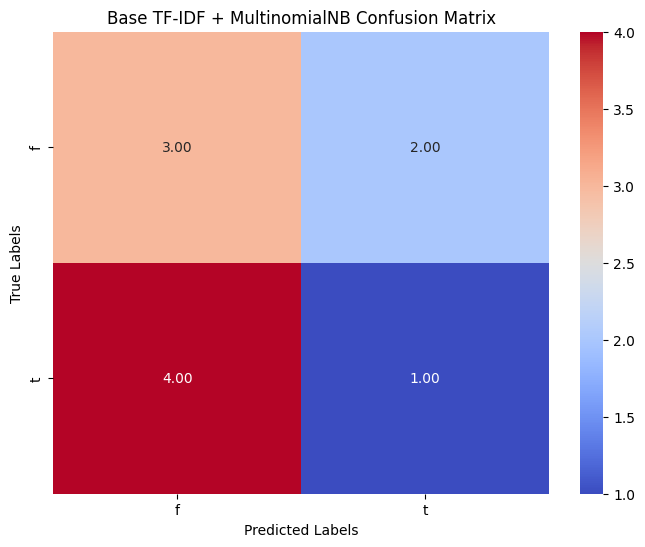


🔹 TF-IDF Sklearn Stops + MultinomialNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.01, 'vectorizer__max_features': 15}
🔹 Accuracy: 0.50
🔹 F1 Score: 0.29
🔹 Recall: 0.20


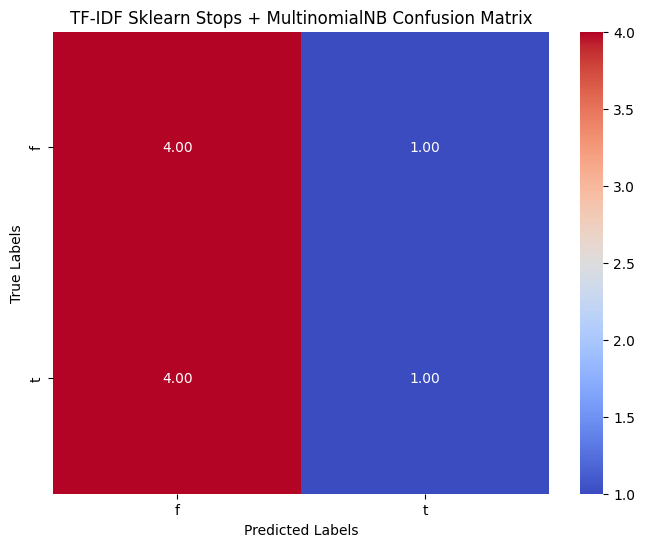


🔹 TF-IDF NLTK Stops + MultinomialNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.5, 'vectorizer__max_features': 15}
🔹 Accuracy: 0.40
🔹 F1 Score: 0.25
🔹 Recall: 0.20


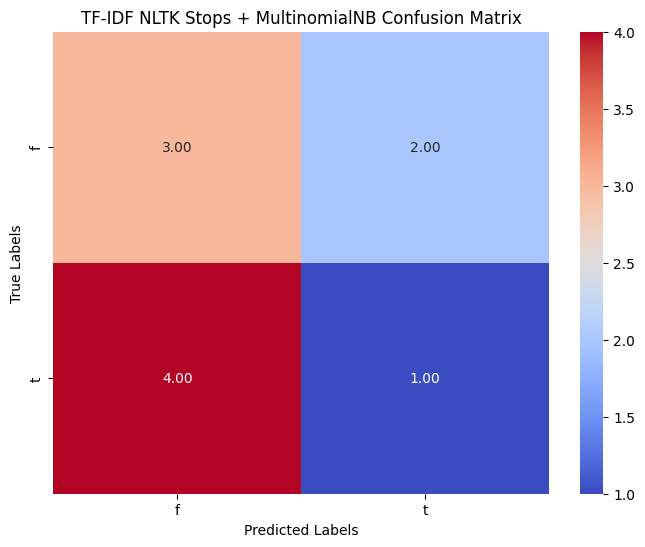


🔹 TF-IDF N-Grams (1,3) + MultinomialNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.1, 'vectorizer__max_features': 50}
🔹 Accuracy: 0.40
🔹 F1 Score: 0.25
🔹 Recall: 0.20


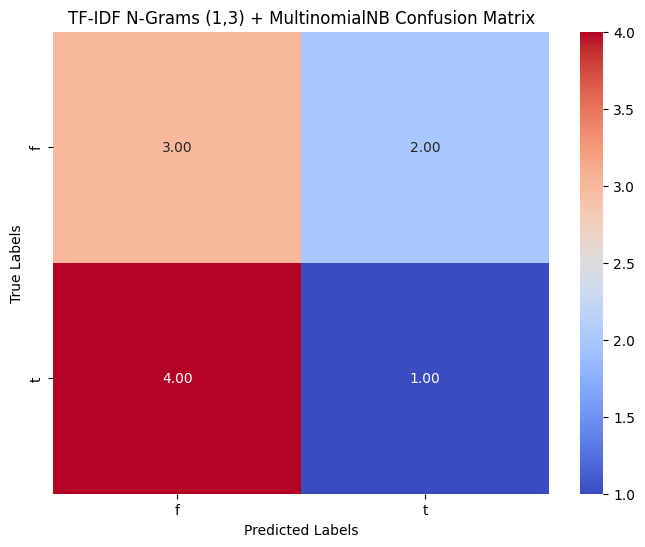


🔹 TF-IDF N-Grams (2,3) + MultinomialNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.25, 'vectorizer__max_features': 50}
🔹 Accuracy: 0.50
🔹 F1 Score: 0.29
🔹 Recall: 0.20


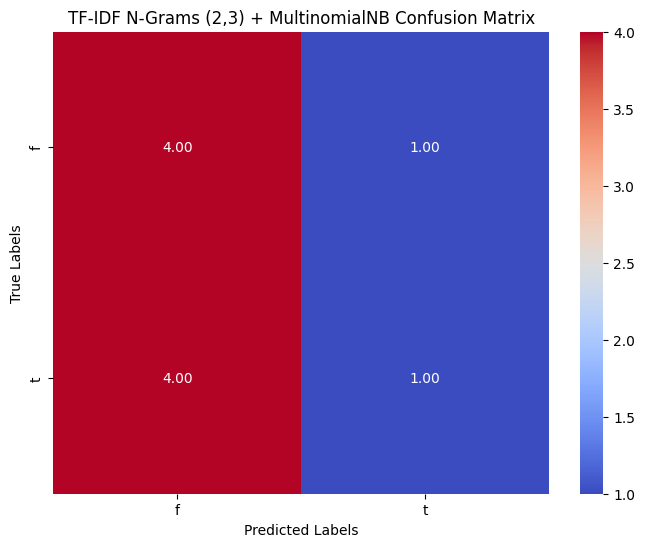


🔹 Base Count + BernoulliNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.5, 'vectorizer__max_features': 100}
🔹 Accuracy: 0.50
🔹 F1 Score: 0.29
🔹 Recall: 0.20


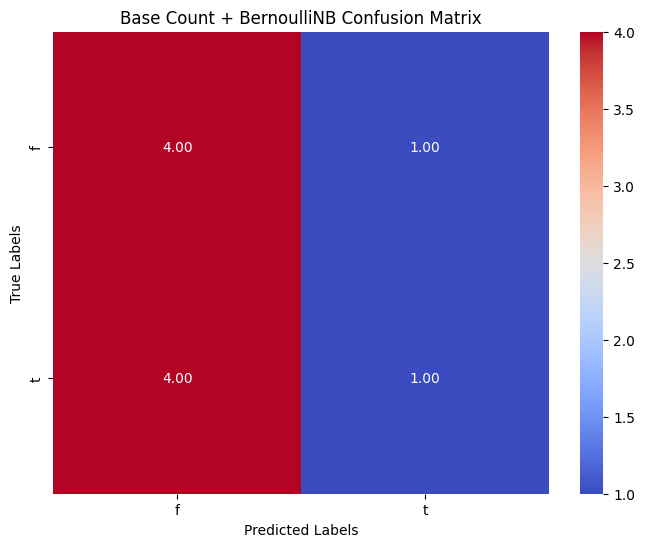


🔹 Count Sklearn Stops + BernoulliNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.75, 'vectorizer__max_features': 15}
🔹 Accuracy: 0.40
🔹 F1 Score: 0.25
🔹 Recall: 0.20


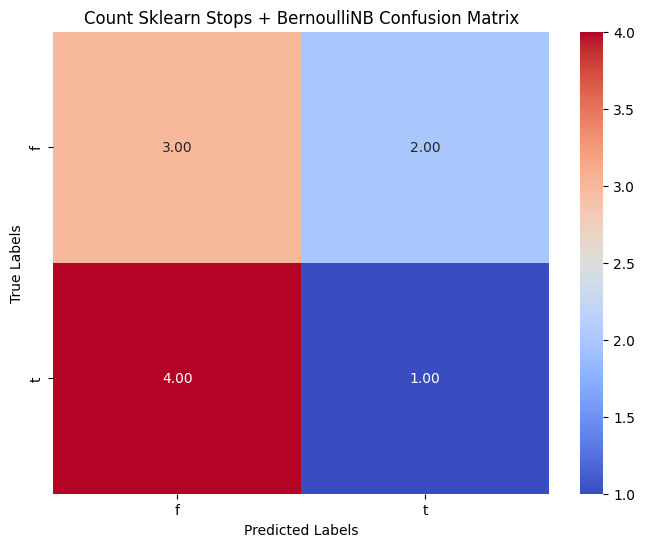


🔹 Count NLTK Stops + BernoulliNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.1, 'vectorizer__max_features': 15}
🔹 Accuracy: 0.70
🔹 F1 Score: 0.67
🔹 Recall: 0.60


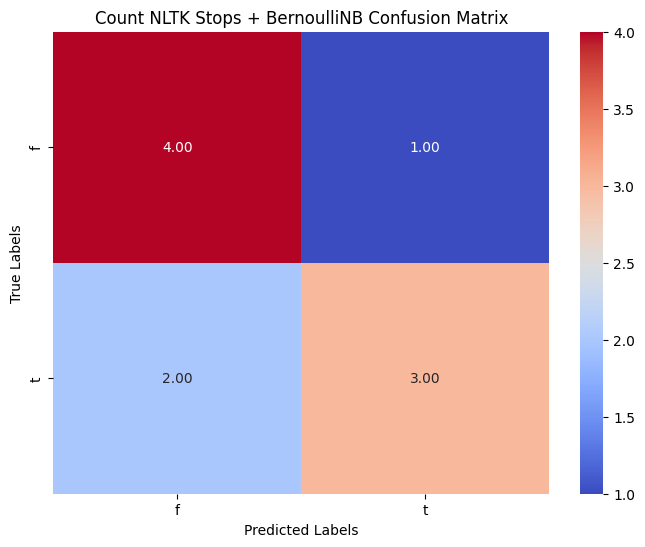


🔹 Count N-Grams (1,3) + BernoulliNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.01, 'vectorizer__max_features': 50}
🔹 Accuracy: 0.50
🔹 F1 Score: 0.29
🔹 Recall: 0.20


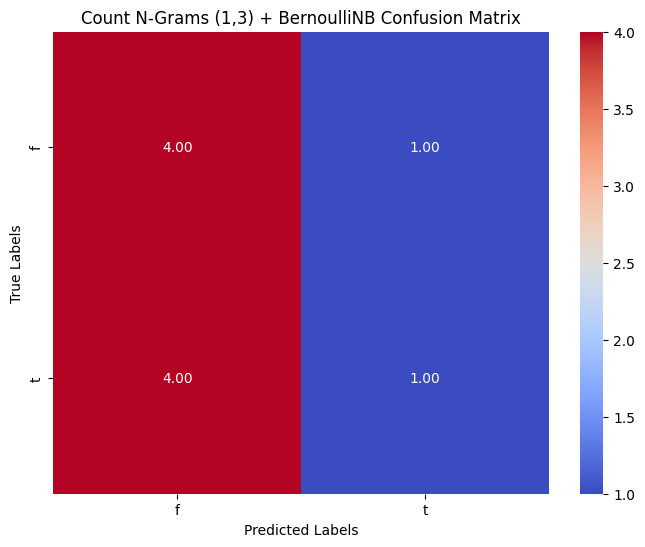


🔹 Count N-Grams (2,3) + BernoulliNB Metrics:
✅ Best Parameters: {'classifier__alpha': 0.5, 'vectorizer__max_features': 50}
🔹 Accuracy: 0.80
🔹 F1 Score: 0.80
🔹 Recall: 0.80


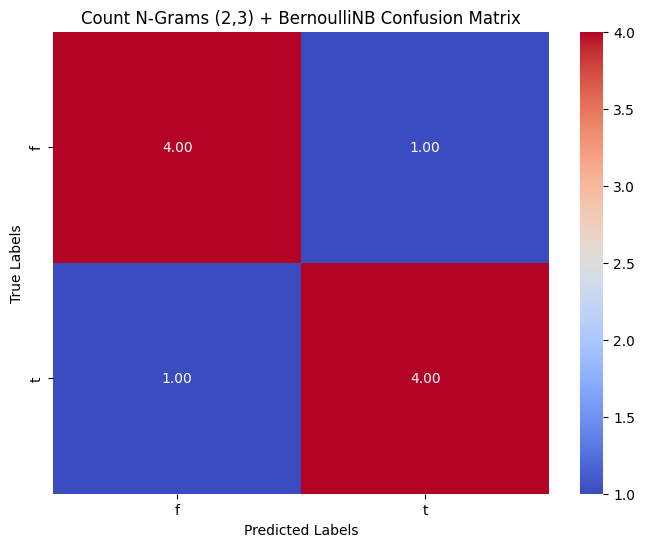

In [51]:
# Print best model parameters and evaluation metrics
for result in lie_metrics:
    print(f"\n🔹 {result['Model']} Metrics:")
    print(f"✅ Best Parameters: {result['Best Params']}")
    print(f"🔹 Accuracy: {result['Accuracy']:.2f}")
    print(f"🔹 F1 Score: {result['F1 Score']:.2f}")
    print(f"🔹 Recall: {result['Recall']:.2f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(result['Confusion Matrix'], annot=True, cmap="coolwarm", fmt=".2f",
                xticklabels=np.unique(y_test_lie), yticklabels=np.unique(y_test_lie))
    plt.title(f"{result['Model']} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [52]:
# Create a DataFrame for comparison
lie_metrics_df = pd.DataFrame(lie_metrics)

# Display the metrics comparison
print("\nLie Metrics Comparison:")
print(lie_metrics_df.iloc[:,:-1])


Lie Metrics Comparison:
                                  Model  \
0           Base TF-IDF + MultinomialNB   
1  TF-IDF Sklearn Stops + MultinomialNB   
2     TF-IDF NLTK Stops + MultinomialNB   
3  TF-IDF N-Grams (1,3) + MultinomialNB   
4  TF-IDF N-Grams (2,3) + MultinomialNB   
5              Base Count + BernoulliNB   
6     Count Sklearn Stops + BernoulliNB   
7        Count NLTK Stops + BernoulliNB   
8     Count N-Grams (1,3) + BernoulliNB   
9     Count N-Grams (2,3) + BernoulliNB   

                                                   Best Params  Accuracy  \
0   {'classifier__alpha': 0.1, 'vectorizer__max_features': 50}       0.4   
1  {'classifier__alpha': 0.01, 'vectorizer__max_features': 15}       0.5   
2   {'classifier__alpha': 0.5, 'vectorizer__max_features': 15}       0.4   
3   {'classifier__alpha': 0.1, 'vectorizer__max_features': 50}       0.4   
4  {'classifier__alpha': 0.25, 'vectorizer__max_features': 50}       0.5   
5  {'classifier__alpha': 0.5, 'vectorizer__ma

# **Results**

For the sentiment label prediction models, the best performing model was the base TFIDF MNB with perfect scores across accuracy, f1 and recall; however this indicates a high level of overfitting which wouldn't generalize well to new data. There is a four-way tie for second place between all but one of the Bernoulli models (the 2,3 ngram performed the worse out of the binary count vectorizers), having perfect recall and accuracy and f1 scores around 90% respectively.


<br><br>

For the lie label prediction models, the best performing model was the count Ngram (2,3) Bernoulli model, showing 80% across the board. The second best model was the count NLTK stops Bernoulli model, with 70% accuracy and about 65% and 60% for f1 and recall respectively. The remaining models performed poorly on avgerage, as accuracy was barely better than a general guess and f1 and recall was about 25% and 20% respectively.

Sentiment model results

<Figure size 1400x600 with 0 Axes>

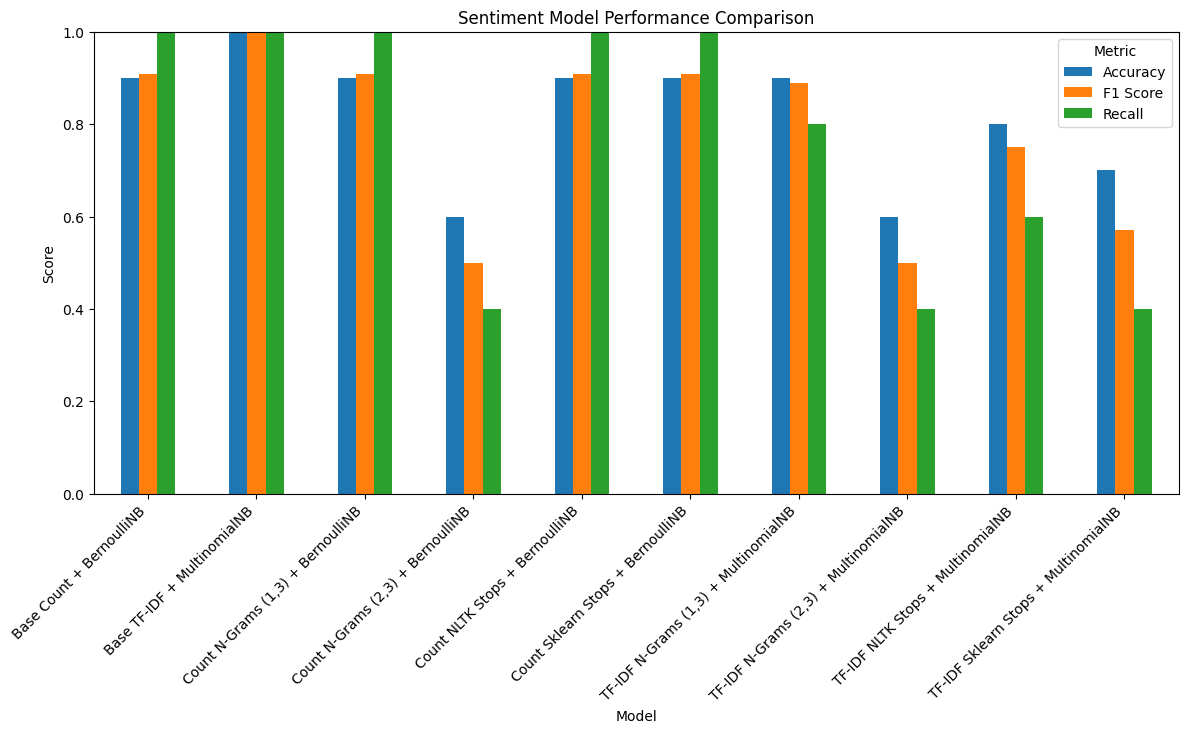

In [46]:
# Melt DataFrame for grouped bar plot
sentiment_melted_df = sentiment_metrics_results_df.melt(id_vars=['Model'], value_vars=['Accuracy', 'F1 Score', 'Recall'],
                            var_name='Metric', value_name='Score')

# Plot comparison bar chart
plt.figure(figsize=(14, 6))
sentiment_melted_df.pivot(index='Model', columns='Metric', values='Score').plot(kind='bar', figsize=(14,6))
plt.title("Sentiment Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Metric")
plt.ylim(0, 1)
plt.show()

Lie model results

<Figure size 1400x600 with 0 Axes>

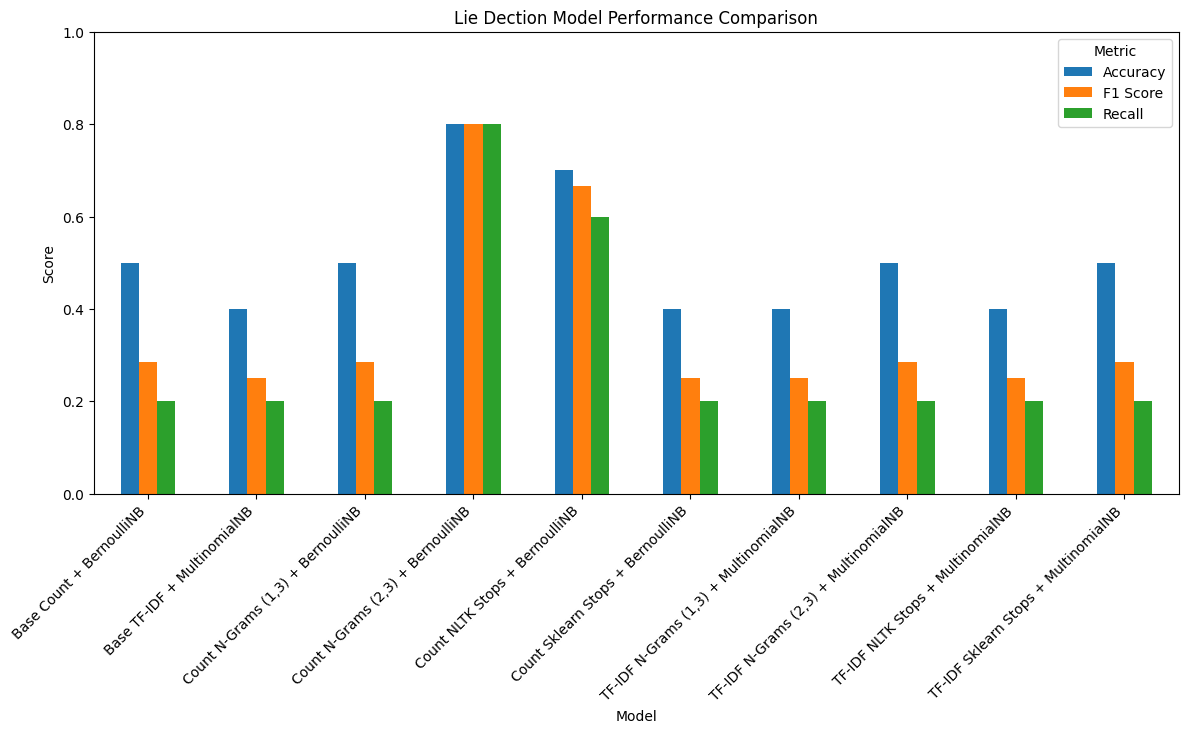

In [53]:
# Melt DataFrame for grouped bar plot
lie_melted_df = lie_metrics_df.melt(id_vars=['Model'], value_vars=['Accuracy', 'F1 Score', 'Recall'],
                            var_name='Metric', value_name='Score')

# Plot comparison bar chart
plt.figure(figsize=(14, 6))
lie_melted_df.pivot(index='Model', columns='Metric', values='Score').plot(kind='bar', figsize=(14,6))
plt.title("Lie Dection Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Metric")
plt.ylim(0, 1)
plt.show()

# **Conclusion:**

Using a broader range of vectorizers in combination with pipeline and gridsearch helps to provide a better idea of which direction to go in with the experimental design and implementation. I was able to get a perfectly trained sentiment model (which I've never done before; previously the most across the board was about 90-92%); additional improvements prior to production would be the utilization of regularization (l1/l2) to improve the models ability to generalize to new data.

<br><br>

For the lie detection model, I was able to improve the performance from previous weeks by utilizing various experiements for this more challenging task . Doing this improved the overall performance of all of the models however additional finetuning is still necessary, as only 2 of the 10 models was able to have metrics of at least 60% across the board. Though lie detection is a more challenging task to address, more time and finetuning could potentially improve the model performance so that they're more aligned with the top two.

<br><br>

For both classification tasks, additional tweaks to parameters like test_split, min_df, number of splits and folds, as well as the use of PCA and other types of dimensionality reduction, and weighting (embeddings, BERT, etc...) should be considered.

In [49]:
# Creating HTML file in colab

%%shell
jupyter nbconvert --to html /content/Nikita_Ramsey_Week6_HW.ipynb

[NbConvertApp] Converting notebook /content/Nikita_Ramsey_Week6_HW.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 34 image(s).
[NbConvertApp] Writing 3913652 bytes to /content/Nikita_Ramsey_Week6_HW.html
